In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

import ipywidgets as widgets
from IPython.display import display, clear_output

Train: (60000, 28, 28) (60000,)  Test: (10000, 28, 28) (10000,)


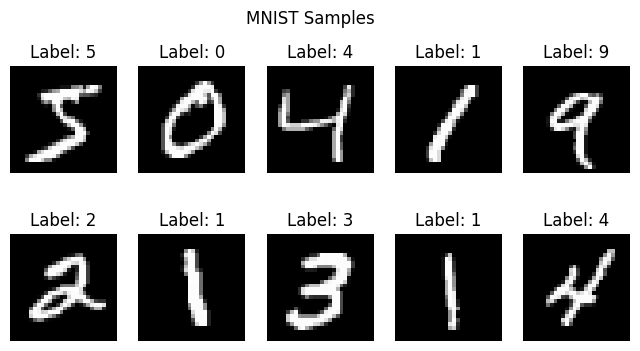

In [5]:
# 2) LOAD MNIST DATASET
from tensorflow.keras.datasets import mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

print("Train:", X_train_full.shape, y_train_full.shape,
      " Test:", X_test.shape, y_test.shape)

# 3) SHOW SAMPLE DIGITS
plt.figure(figsize=(8,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(X_train_full[i], cmap="gray")
    plt.title(f"Label: {y_train_full[i]}")
    plt.axis("off")
plt.suptitle("MNIST Samples")
plt.show()

In [8]:
# 4) PREPARE DATA FOR BOTH TYPES OF MODELS
X_train_flat = X_train_full.reshape(-1, 28*28) / 255.0
X_test_flat  = X_test.reshape(-1, 28*28) / 255.0

X_train_img = X_train_full / 255.0
X_test_img  = X_test / 255.0
y_train = y_train_full

In [10]:
# 5) SKLEARN MODELS
models = {
    "LogisticRegression": LogisticRegression(max_iter=200, solver="lbfgs", multi_class="multinomial"),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
}

results = {}
for name, model in models.items():
    model.fit(X_train_flat, y_train)
    pred = model.predict(X_test_flat)
    acc = accuracy_score(y_test, pred)
    results[name] = (acc, pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, pred))

# 6) NEURAL NETWORK (Keras)
nn = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(128, activation="relu"),
    Dense(10, activation="softmax")
])
nn.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
nn.fit(X_train_img, y_train, epochs=3, batch_size=128, verbose=1, validation_split=0.1)

loss, acc = nn.evaluate(X_test_img, y_test, verbose=0)
results["NeuralNet"] = (acc, None)
print(f"\nNeural Net Accuracy: {acc:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



LogisticRegression Accuracy: 0.9265
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.91      0.91      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.90      0.87      0.88       892
           6       0.94      0.95      0.95       958
           7       0.94      0.92      0.93      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000


RandomForest Accuracy: 0.9704
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
          

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8179 - loss: 0.6712 - val_accuracy: 0.9530 - val_loss: 0.1751
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9437 - loss: 0.1963 - val_accuracy: 0.9675 - val_loss: 0.1273
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9606 - loss: 0.1372 - val_accuracy: 0.9670 - val_loss: 0.1149

Neural Net Accuracy: 0.9615


In [12]:
# 8) GUI FOR PREDICTION
model_dd = widgets.Dropdown(options=list(results.keys()), value="RandomForest", description="Model:")
img_index = widgets.IntSlider(min=0, max=1000, value=0, description="Image Index")
pred_btn = widgets.Button(description="Predict", button_style="primary")
out = widgets.Output()

def on_predict_clicked(_):
    with out:
        clear_output(wait=True)
        idx = img_index.value
        img = X_test[idx]
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.show()
        model_name = model_dd.value
        if model_name == "NeuralNet":
            pred = np.argmax(nn.predict(X_test_img[idx].reshape(1,28,28)), axis=1)[0]
            acc = results["NeuralNet"][0]
        else:
            model = models[model_name]
            pred = model.predict(X_test_flat[idx].reshape(1,-1))[0]
            acc = results[model_name][0]
        print(f"True: {y_test[idx]} | Predicted: {pred}")
        print(f"Model: {model_name} | Test Accuracy: {acc:.3f}")

pred_btn.on_click(on_predict_clicked)
ui = widgets.VBox([model_dd, img_index, pred_btn, out])
display(ui)

with out:
    print("Ready. Pick an image index and click Predict.")